In [1]:
import torch  
%pylab

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [48]:
T = 1.0          # Arbitrary amount time, roughly physiological.
ntimesteps = 25  # Divide T into this many bins
bval = 0.01      # bias value limit
sval = 0.025     # standard deviation (before dividing by sqrt(dt))
input_params = (bval, sval, T, ntimesteps)

# GRU and task hyperparameters
u = 1         # Number of inputs to the GRU
n = 100       # Number of units in the GRU
o = 1         # Number of outputs in the GRU

# Optimization hyperparameters
num_batchs = 10000        # Total number of batches to train on.
batch_size = 128          # How many examples in each batch
eval_batch_size = 1024    # How large a batch for evaluating the RNN
step_size = 0.04          # initial learning rate
decay_factor = 0.9999     # decay the learning rate this much
# Gradient clipping is HUGELY important for training all RNN varieties
max_grad_norm = 10.0      # max gradient norm before clipping, clip to this value.
l2reg = 0.00002           # amount of L2 regularization on the weights
adam_b1 = 0.9             # Adam parameters
adam_b2 = 0.999
adam_eps = 1e-1
print_every = 100          # Print training informatino every so often

In [49]:
def get_noise_dataset(input_params):
    (bval, sval, T, ntimesteps) = input_params
    normal = torch.distributions.normal.Normal(0, 1)
    
    dt = torch.FloatTensor([T/ntimesteps])
    
    bsample = normal.sample([1])
    b = bval * 2. * (bsample - 0.5) 
    
    stddev = sval / torch.sqrt(dt)
    vsample = normal.sample([ntimesteps])
    
    noise = vsample * stddev
    white_noise = noise + b
    
    true_integral = torch.cumsum(white_noise, 0)
    final_target = torch.Tensor([1.0*((true_integral[-1] > 0.0)-0.5)])
    
    target_t = torch.zeros(true_integral.shape[0]-1)
    targets_t = torch.cat([target_t, final_target], dim=0)
    
    return white_noise, targets_t
    
def generate_batch(batch_size, input_params):
    
    noises, targets = [], []
    
    for i in range(batch_size):
        n, t = get_noise_dataset(input_params)
        noises.append(n)
        targets.append(t)
        
    return torch.stack(noises).transpose(1, 0)[:, :, None].cuda(), torch.stack(targets).transpose(1, 0)[:, :, None].cuda()
    
    
    

In [50]:
noise, target = get_noise_dataset(input_params)

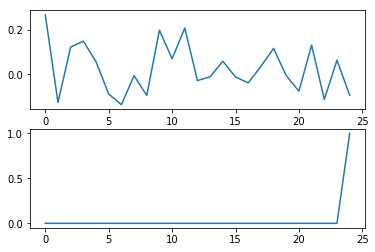

In [51]:
ax = plt.subplot(211)
ax.plot(noise.numpy())
ax = plt.subplot(212)
ax.plot(target.numpy())

# GRU

In [215]:
class Simple_GRU(torch.nn.Module):
    
    def __init__(self, u, n, o, use_cuda=True):
        super(Simple_GRU, self).__init__()
        self.gru = torch.nn.GRUCell(u, n)
        self.readout = torch.nn.Linear(n, o)
        self.init_s = torch.nn.Parameter(torch.randn(1,n))
        
        
    def forward(self, x):
        
        hs = []
        
        batch_size = x.shape[1]
        h = self.init_s.repeat((batch_size, 1))
        for x_t in x:
            h = self.gru(x_t, h)
            hs.append(h)
        out = self.readout(h)
        
        return out, torch.stack(hs)


In [196]:

gru.init_s.repeat((100, 1)).shape

torch.Size([100, 100])

In [149]:
adam = torch.optim.Adam(gru.parameters(), 
                        step_size, 
                        (adam_b1, adam_b2), 
                        adam_eps,
                       l2reg)
optim = torch.optim.lr_scheduler.ExponentialLR(adam, decay_factor)

In [150]:
noise, targets = generate_batch(batch_size, input_params)

In [151]:
mse = torch.nn.MSELoss().cuda()
def loss(pred, targets):
    targets = targets[-1, :, :]
    return mse(pred, targets)
    

In [152]:
loss(gru(noise)[0], targets)

tensor(0.2799, device='cuda:0', grad_fn=<MseLossBackward>)

In [153]:
for i_batch in range(num_batchs):
    optim.optimizer.zero_grad()
    
    noise, targets = generate_batch(batch_size, input_params)
    
    pred, hs  = gru(noise)
    train_loss = loss(pred, targets)
    train_loss.backward()
    torch.nn.utils.clip_grad_norm(gru.parameters(),max_grad_norm)
    optim.step()
    optim.optimizer.step()
    if i_batch % print_every == 0:
        print(i_batch, optim.optimizer.param_groups[0]['lr'], train_loss.item())

        
    


/home/lucas/anaconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if __name__ == '__main__':


0 0.039996000000000004 0.35535570979118347
100 0.03959801335030015 0.21896807849407196
200 0.03920398693095678 0.20208364725112915
300 0.03881388133505894 0.210484579205513
400 0.038427657547820473 0.18815505504608154
500 0.03804527694267816 0.086219422519207
600 0.037666701277428626 0.1056012213230133
700 0.03729189269040369 0.08169206976890564
800 0.036920813696683756 0.06691699475049973
900 0.0365534271843491 0.056260425597429276
1000 0.036189696410768024 0.040991246700286865
1100 0.03582958499892238 0.04779032617807388
1200 0.03547305693376938 0.08369410037994385
1300 0.03512007655863975 0.05387963354587555
1400 0.03477060857167165 0.029418211430311203
1500 0.03442461802228005 0.04150514677166939
1600 0.03408207030766145 0.038464393466711044
1700 0.03374293116933307 0.035046808421611786
1800 0.03340716668970668 0.031797558069229126
1900 0.03307474328869652 0.03037354163825512
2000 0.03274562772036086 0.032009005546569824
2100 0.03241978706957714 0.045300669968128204
2200 0.03209718

In [154]:
noise, targets = generate_batch(eval_batch_size, input_params)
pred, hiddens  = gru(noise)
loss(pred, targets)

tensor(0.0203, device='cuda:0', grad_fn=<MseLossBackward>)

In [155]:
hiddens.shape

torch.Size([25, 1024, 100])

## Fixed points

In [325]:
# Fixed point optimization hyperparameters
fp_num_batches = 1400         # Total number of batches to train on.
fp_batch_size = 128          # How many examples in each batch
fp_step_size = 0.2          # initial learning rate
fp_decay_factor = 0.9999     # decay the learning rate this much
fp_decay_steps = 1           #
fp_adam_b1 = 0.9             # Adam parameters
fp_adam_b2 = 0.999
fp_adam_eps = 1e-5
fp_opt_print_every = 200   # Print training information during optimziation every so often

# Fixed point finding thresholds and other HPs
fp_noise_var = 0.0      # Gaussian noise added to fixed point candidates before optimization.
fp_opt_stop_tol = 0.00001  # Stop optimizing when the average value of the batch is below this value.
fp_tol = 0.00001        # Discard fps with squared speed larger than this value.
fp_unique_tol = 0.025   # tolerance for determination of identical fixed points
fp_outlier_tol = 1.0    # Anypoint whos closest fixed point is greater than tol is an outlier.

In [326]:
_, hiddens = gru(noise)

In [327]:
fp_candidates.shape

torch.Size([25600, 100])

In [328]:
candidates = hiddens.view(-1, 100)
fp_candidates = torch.nn.Parameter(candidates.clone())
x_star = torch.zeros((25600, 1)).cuda()

fp_opt = torch.optim.Adam([fp_candidates], 
                         fp_step_size,
                         (fp_adam_b1,fp_adam_b2),
                         fp_adam_eps,
                         )   

fp_mse = torch.nn.MSELoss(reduce=False).cuda()
for i in range(fp_num_batches):


    fp_opt.zero_grad()
    h_new = gru.gru(x_star, fp_candidates)
    fp_loss = fp_mse(h_new, fp_candidates)
    
    mse = torch.mean(fp_loss)
    
    mse.backward()
    fp_opt.step()
    
    if i % fp_opt_print_every == 0:
        print(mse)
        
        

tensor(0.0024, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.8507e-05, device='cuda:0', grad_fn=<MeanBackward0>)


In [347]:
speeds = torch.mean(fp_mse(fp_candidates, h_new), dim=1)
best_fps = fp_candidates[speeds < fp_tol]
fps = best_fps.cpu().detach().numpy()

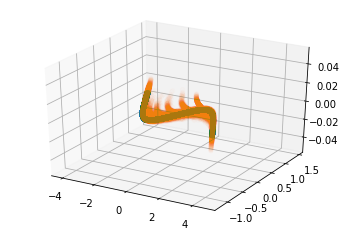

In [363]:
readouts = gru.readout(best_fps).cpu().detach().numpy()

In [399]:
readouts[sorted_idxs].shape

(18917, 1)

In [393]:
sorted_idxs = np.argsort(readouts, axis=0).squeeze()
sorted_fps = best_fps[sorted_idxs].cpu().detach().numpy()

In [394]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [395]:
pca = PCA(3).fit(sorted_fps)
pc_fps = pca.transform(sorted_fps)


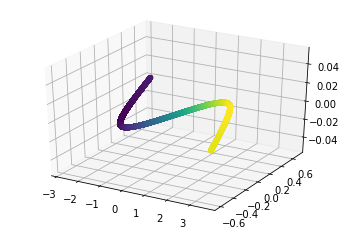

In [400]:
ax = plt.subplot(111, projection='3d')
ax.scatter(pc_fps.T[0], pc_fps.T[1], c=readouts[sorted_idxs].squeeze())
